### Mental Health Locations Project
by Ethan Chu

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, t
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv("mental_health_locations.csv", encoding = "windows-1252")
df.head()

,ï»¿TYPE,LICENSEE,PROGRAM NAME,AUTHORIZATION,LICENSING \nDEPARTMENT,BEDS,COUNTY,FACILITY ADDRESS,CITY,ZIP CODE,CERTIFICATE NUMBER,STATE,LOCATION
0,STRTP (Short-Term Residential Therapeutic Prog...,4 Kids 2 Kids,4 Kids 2 Kids-Safe House (Strtp),Approved,CDSS,6,Santa Barbara,Unknown,Carpinteria,93013,MH/42/01/19,California,"Santa Barbara, California"
1,STRTP (Short-Term Residential Therapeutic Prog...,All Of God'S Children'S Group Home,All Of God'S Children Group Home,Approved,CDSS,8,Riverside,Unknown,Moreno Valley,92555,MH/33/04/22,California,"Riverside, California"
2,STRTP (Short-Term Residential Therapeutic Prog...,All Of God'S Children'S Group Home,All Of God'S Children Group Home,Approved,CDSS,8,Riverside,Unknown,Moreno Valley,92555,MH/33/03/22,California,"Riverside, California"
3,STRTP (Short-Term Residential Therapeutic Prog...,Amali,Amali,Approved,CDSS,6,San Diego,Unknown,Spring Valley,91977,MH/37/01/24,California,"San Diego, California"
4,STRTP (Short-Term Residential Therapeutic Prog...,Amali,Amali,Approved,CDSS,6,San Diego,Unknown,Spring Valley,91977,MH/37/02/24,California,"San Diego, California"


In [17]:
df.columns

Index(['ï»¿TYPE', 'LICENSEE', 'PROGRAM NAME', 'AUTHORIZATION',
       'LICENSING \nDEPARTMENT', 'BEDS', 'COUNTY', 'FACILITY ADDRESS', 'CITY',
       'ZIP CODE', 'CERTIFICATE NUMBER', 'STATE', 'LOCATION'],
      dtype='object')

In [3]:
df_certified = df[df["AUTHORIZATION"] == "Certified"]
df_approved = df[df["AUTHORIZATION"] == "Approved"]

### How do the number of beds differ between Certified Programs and Approved Programs? Does that have any correlation with the number of programs each program type has?

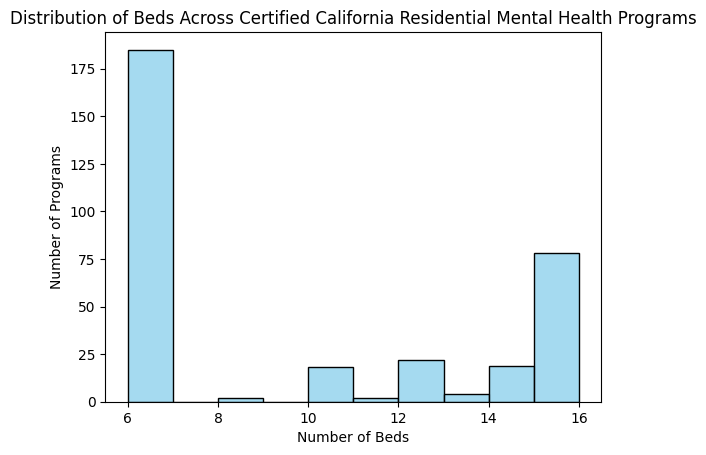

In [4]:
sns.histplot(df_certified['BEDS'], color = 'skyblue', bins = 10)
plt.xlabel("Number of Beds")
plt.ylabel("Number of Programs")
plt.title("Distribution of Beds Across Certified California Residential Mental Health Programs")
plt.show()

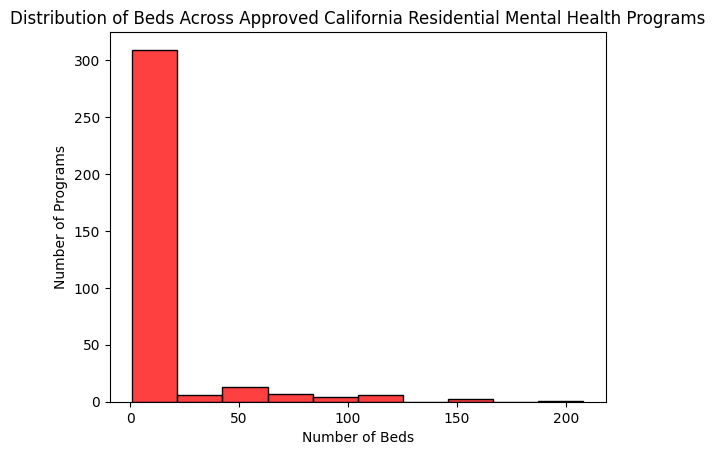

In [5]:
sns.histplot(df_approved['BEDS'], color = 'red', bins = 10)
plt.xlabel("Number of Beds")
plt.ylabel("Number of Programs")
plt.title("Distribution of Beds Across Approved California Residential Mental Health Programs")
plt.tight_layout
plt.show()

From the two histograms above, we can see that approved residential mental health programs in California have a larger range of beds compared to certified residential mental health programs. Let's compare the average number of beds for each type of authorization.

### Confidence Intervals!
Let's construct 95% confidence intervals for the true mean number of beds for each program authorization with the population being ALL residential mental health programs.

#### Conditions and Assumptions
1) Random sampling -> not met because these residential mental health programs are only located in California, so they are not representative of the whole population of all residential mental health programs
2) Independence of observations -> mostly met because each residential mental health program supplies its own beds, but some programs may be financially dependent on other programs, making funding for one observation contingent on another, thus funds for beds are not entirely independent
3) Normally distributed data / large sample size -> met because our sample size n > 30
4) Sample size is greater than 10% of population -> met because there are more than 6780 residential mental health programs in the world (this sample has 678 programs)

#### Certified Programs!

In [6]:
point_estimate = df_certified["BEDS"].mean()
point_estimate

np.float64(9.493939393939394)

In [7]:
standard_error = df_certified["BEDS"].std() / np.sqrt(len(df_certified["BEDS"]))
standard_error

np.float64(0.2320558963145498)

In [8]:
critical_value = norm.ppf(0.975)
critical_value

np.float64(1.959963984540054)

In [9]:
lower_bound = point_estimate - (critical_value * standard_error)
upper_bound = point_estimate + (critical_value * standard_error)
print(f"({lower_bound}, {upper_bound})")

(9.039118194762715, 9.948760593116074)


#### Approved Programs!

In [10]:
point_estimate = df_approved["BEDS"].mean()
point_estimate

np.float64(14.887931034482758)

In [11]:
standard_error = df_approved["BEDS"].std() / np.sqrt(len(df_approved["BEDS"]))
standard_error

np.float64(1.3832214013484747)

In [12]:
critical_value = norm.ppf(0.975)
critical_value

np.float64(1.959963984540054)

In [13]:
lower_bound = point_estimate - (critical_value * standard_error)
upper_bound = point_estimate + (critical_value * standard_error)
print(f"({lower_bound}, {upper_bound})")

(12.176866905194725, 17.59899516377079)


#### Comparing Confidence Intervals

For certified programs: Our 95% confidence interval of (9.039118194762715, 9.948760593116074) suggests that we are 95% confident that the true mean number of beds in certified residential mental health programs is between 9.039 and 9.949 beds. In other words, we are pretty sure that a certified residential mental health program has between 9.039 and 9.949 beds for its patients. However, we should be skeptical of these results since not all conditions for constructing a confidence interval were met. To make this conclusion more reliable, we should get a large random sample of all residential mental health programs and then reconstruct a 95% confidence interval.

### Hypothesis Testing: are the average number of beds the same between certified and approved programs?
$H_0: \mu_1 - \mu_2 = 0$

$H_a: \mu_1 - \mu_2 \neq 0$

where $\mu_1$ is the mean number of beds in certified programs and $\mu_2$ is the mean number of beds in approved programs.

#### Conditions
1) Sample of certified programs is randomly selected -> not met because the overall sample is not randomly selected
2) Sample size of certified programs is less than 10% of all certified programs -> met
3) Sample size of certified programs is > 30 or sample distribution is approximately normal -> met
4) Sample of approved programs is randomly selected -> not met because the overall sample is not randomly selected
5) Sample size of approved programs is less than 10% of all certified programs -> met
6) Sample size of approved programs is > 30 or sample distribution is approximately normal -> met
7) The samples are independent of each other, no pairwise relationship -> mostly met, there may be existing relationships between some certified and approved programs due to some confounding factors such as licensee, funding sources, etc. that may affect how many beds each program has

In [17]:
point_estimate = df_certified["BEDS"].mean() - df_approved["BEDS"].mean()
standard_error = np.sqrt((df_certified["BEDS"].std() ** 2) / len(df_certified) + (df_approved["BEDS"].std() ** 2) / len(df_approved))
test_statistic = (point_estimate - 0) / standard_error

In [18]:
p_val = 2 * (1 - t.cdf(np.abs(test_statistic), df = min(len(df_certified) - 1, len(df_approved) - 1)))
p_val

np.float64(0.0001442522399606183)

#### Conclusion
Because our p-value of 0.000144 is less than our significance level 0.05, we have statistically significant evidence reject the null hypothesis, suggesting that the mean number of beds between certified and approved programs is not 0. As such, the type of authorization a residential mental health program has does seem to have a strong effect on the number of beds each program has. However, because not all the conditions for running a hypothesis test were met, we should still be skeptical of this result.

### Statistical Modeling

Let's create a statistical model to determine the effects of various explanatory variables (Licensee, County, etc) on the number of beds a residential mental health program has.

#### Linear Regression

In [21]:
results = smf.ols("BEDS ~ COUNTY+AUTHORIZATION", data = df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BEDS   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.254
Date:                Thu, 15 Jan 2026   Prob (F-statistic):              0.135
Time:                        19:23:53   Log-Likelihood:                -2927.3
No. Observations:                 678   AIC:                             5941.
Df Residuals:                     635   BIC:                             6135.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     19.3590      4.358      4.442      0.000      10.801      27.917
COUNTY[T.Alpine]             -13.3590     13.958     -0.957      0.339     -40.767      14.049
COUNTY[T.Butte]               -4.4724      9.430     -0.474      0.635     -22.990      14.045
COUNTY[T.Calaveras]           -3.3590     11.671     -0.288      0.774     -26.277      19.559
COUNTY[T.Contra Costa]        -7.6146      6.369     -1.196      0.232     -20.122       4.892
COUNTY[T.El Dorado]           -8.2289      8.295     -0.992      0.322     -24.517       8.060
COUNTY[T.Fresno]              -9.8182      5.390     -1.821      0.069     -20.403       0.767
COUNTY[T.Humboldt]            -5.0406     11.657     -0.432      0.666     -27.931      17.850
COUNTY[T.Imperial]            -7.5331     11.651     -0.647      0.518     -30.412      15.346
COUNTY[T.Kern]               -12.8778      5.565     -2.314      0.021     -23.806      -1.949
COUNTY[T.Kings]              -13.3590     19.252     -0.694      0.488     -51.164      24.446
COUNTY[T.Lassen]              -9.3590     19.252     -0.486      0.627     -47.164      28.446
COUNTY[T.Los Angeles]          0.9888      4.605      0.215      0.830      -8.055      10.032
COUNTY[T.Madera]              -8.3590     13.958     -0.599      0.549     -35.767      19.049
COUNTY[T.Marin]               -3.6314      7.961     -0.456      0.648     -19.265      12.002
COUNTY[T.Mariposa]           -13.3590     19.252     -0.694      0.488     -51.164      24.446
COUNTY[T.Mendocino]          -10.1202     13.941     -0.726      0.468     -37.496      17.255
COUNTY[T.Merced]              13.5539      8.792      1.542      0.124      -3.710      30.818
COUNTY[T.Monterey]            -1.7508     10.330     -0.169      0.865     -22.036      18.535
COUNTY[T.Napa]                -1.8814     13.973     -0.135      0.893     -29.320      25.557
COUNTY[T.Nevada]               4.1186     19.263      0.214      0.831     -33.708      41.946
COUNTY[T.Orange]              -4.1872      4.809     -0.871      0.384     -13.630       5.256
COUNTY[T.Placer]               0.0320      9.425      0.003      0.997     -18.476      18.541
COUNTY[T.Placerville]         -5.8814     19.263     -0.305      0.760     -43.708      31.946
COUNTY[T.Riverside]           -5.0465      5.102     -0.989      0.323     -15.065       4.972
COUNTY[T.Sacramento]          -5.7581      5.815     -0.990      0.322     -17.176       5.660
COUNTY[T.San Bernardino]      -5.2744      4.939     -1.068      0.286     -14.974       4.425
COUNTY[T.San Diego]           -2.8404      5.106     -0.556      0.578     -12.867       7.187
COUNTY[T.San Francisco]       -1.5106      6.134     -0.246      0.806     -13.556      10.535
COUNTY[T.San Joaquin]          5.0753      